In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from functools import partial
from lie_learn.groups.SO3 import change_coordinates as SO3_coordinates
from lie_vae.lie_tools import log_map, rodrigues, map2LieVector, group_matrix_to_eazyz
from lie_vae.nets import ChairsDeconvNet, ChairsEncoder
from lie_vae.decoders import ActionNetWrapper as ActionNet, MLPNet
from lie_vae.datasets import ShapeDataset, SelectedDataset
from lie_vae.utils import encode
from lie_vae.vae import ChairsVAE

In [2]:
def plot_output(images, title=""):
    fig, ax = plt.subplots(1, 10, figsize=(20, 3))
    for ax, im in zip(ax.flatten(), images):
        ax.imshow(im[0].detach(), 'gray')
        ax.set_axis_off()
    fig.suptitle(title)
    fig.tight_layout()
    
def rotation_interpolation():
    start = torch.rand(3)[None] * 5
    end = torch.rand(3)[None] * 5
    t = torch.linspace(0, 1, 10)[:, None]
    x = (1-t) * start + end * t
    return rodrigues(x).detach()

def plot_reconstructions(versions, titles):
    n_versions = len(versions)
    n_images = len(versions[0])
    
    fig, ax = plt.subplots(n_images, n_versions, figsize=(10, 10))
    for i in range(n_images):
        for j in range(n_versions):
            ax[i, j].imshow(versions[j][i][0].detach(), 'gray')
            ax[i, j].set_axis_off()
            if i == 0:
                ax[i, j].set_title(titles[j])
    fig.tight_layout()

In [3]:
from collections import OrderedDict
from functools import partial
import re
def trasform_state_keys(pattern, fn, state):
    """Transformed saved state"""
    return OrderedDict(
        [(re.sub(pattern, fn, k), v) for k, v in state.items()]
    )

# For change in deconv nn.Sequential
transform_state_deconv = partial(trasform_state_keys, r'deconv\.(\d)+', lambda i: 'deconv.'+str(int(i.group(1))+1))

def load_transform_deconv(path):
    return transform_state_deconv(torch.load(path))

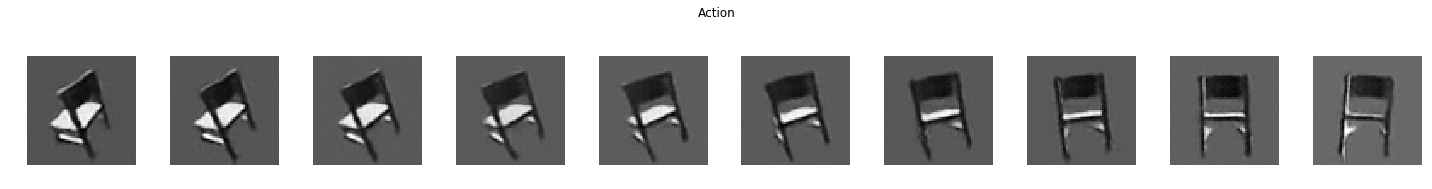

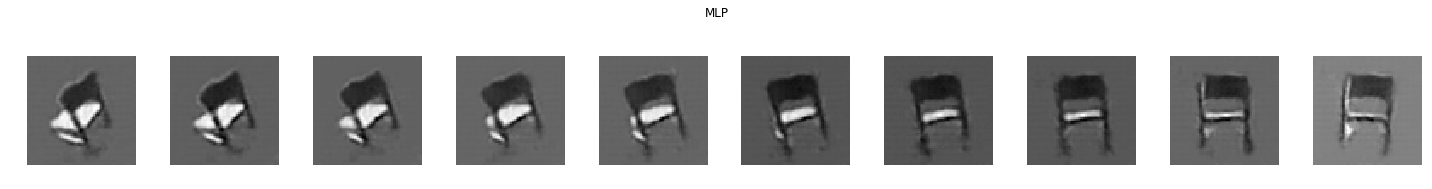

In [4]:
action_net = ActionNet(6, ChairsDeconvNet(490, 50))
action_net.load_state_dict(load_transform_deconv('supervised_outputs/action.pickle'))
mlp_net = MLPNet(6, ChairsDeconvNet(490, 50))
mlp_net.load_state_dict(load_transform_deconv('supervised_outputs/mlp.pickle'))

rot = rotation_interpolation()
action_outputs = action_net(rot)
mlp_outputs = mlp_net(rot)
    
plot_output(action_outputs, 'Action')
plot_output(mlp_outputs, 'MLP')

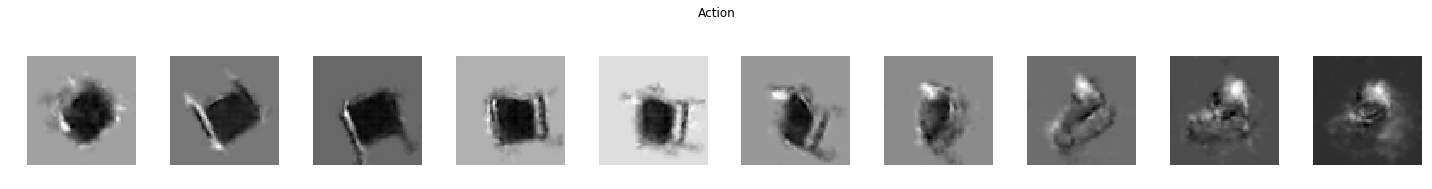

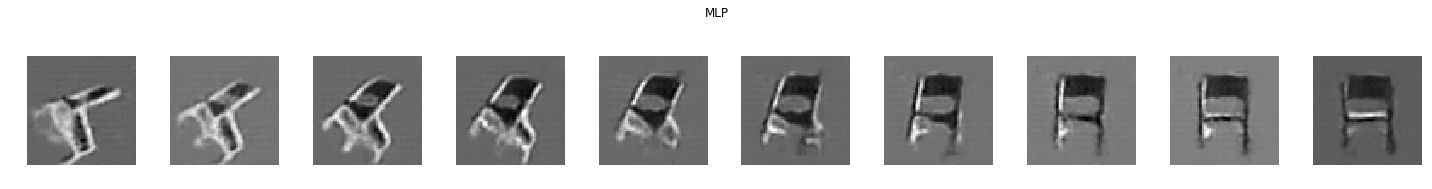

In [5]:
action_net = ActionNet(3, ChairsDeconvNet(160, 50))
action_net.load_state_dict(load_transform_deconv('ae_outputs/action_100.pickle'))
action_net_enc = ChairsEncoder()
state = torch.load('ae_outputs/action_100_enc.pickle')
for i in range(0, 10, 2):  # Trained without bias
    state['conv.%d.bias' % i] = torch.zeros(state['conv.%d.weight' % i].size(0))
action_net_enc.load_state_dict(state)

action_net_fat = ActionNet(8, ChairsDeconvNet(810, 200))
action_net_fat.load_state_dict(load_transform_deconv('ae_outputs/fat/action_100.pickle'))
action_net_enc_fat = ChairsEncoder()
state = torch.load('ae_outputs/fat/action_100_enc.pickle')
for i in range(0, 10, 2):  # Trained without bias
    state['conv.%d.bias' % i] = torch.zeros(state['conv.%d.weight' % i].size(0))
action_net_enc_fat.load_state_dict(state)

rot = rotation_interpolation()
action_outputs = action_net(rot)
action_fat_outputs = action_net_fat(rot)
mlp_outputs = mlp_net(rot)
    
# plot_output(action_outputs, 'Action')
plot_output(action_fat_outputs, 'Action')
plot_output(mlp_outputs, 'MLP')

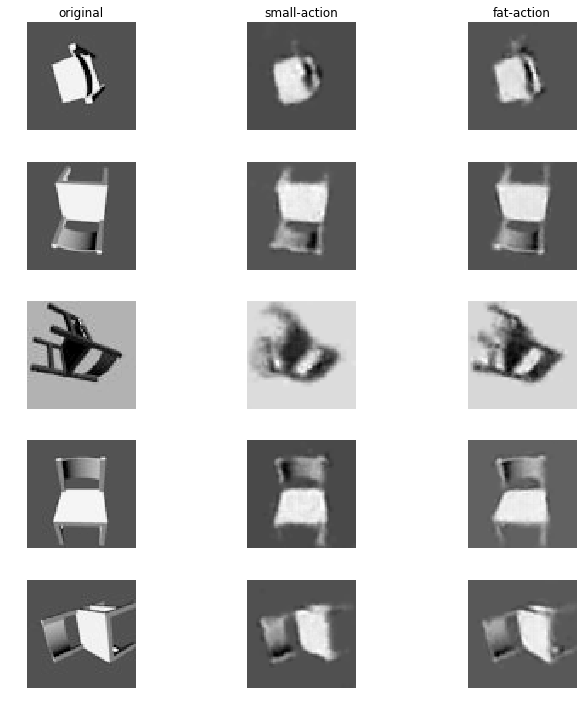

In [6]:
dataset = ShapeDataset('data/chairs/single/')
idxs = np.random.choice(len(dataset), size=5, replace=False)
images = torch.stack([dataset[i][2] for i in idxs], 0)
reconstructions = action_net(action_net_enc(images)[0])
reconstructions_fat = action_net_fat(action_net_enc_fat(images)[0])
    
plot_reconstructions([images, reconstructions, reconstructions_fat],
                     ['original', 'small-action', 'fat-action'])

In [7]:
multi_dataset = SelectedDataset()

In [8]:
# multi_action_dec = ActionNet(3, single_id=False)
# multi_action_dec.load_state_dict(torch.load('multi_outputs/ae-action/action_4.pickle'))
# multi_action_enc = Encoder(id_dims=10)
# multi_action_enc.load_state_dict(torch.load('multi_outputs/ae-action/action_4_enc.pickle'))

multi_action_dec_fat = ActionNet(6, ChairsDeconvNet(490, 200), single_id=False, content_dims=30)
multi_action_dec_fat.load_state_dict(load_transform_deconv('multi_outputs/ae-action-fat/action_7.pickle'))
multi_action_enc_fat = ChairsEncoder(content_dims=30)
multi_action_enc_fat.load_state_dict(torch.load('multi_outputs/ae-action-fat/action_7_enc.pickle'))


multi_mlp_dec = MLPNet(3, ChairsDeconvNet(160, 200), single_id=False, content_dims=30)
multi_mlp_dec.load_state_dict(load_transform_deconv('multi_outputs/ae-mlp/mlp_9.pickle'))
multi_mlp_enc = ChairsEncoder(content_dims=30)
multi_mlp_enc.load_state_dict(torch.load('multi_outputs/ae-mlp/mlp_9_enc.pickle'))

multi_action_dec_fat8 = ActionNet(6, ChairsDeconvNet(490, 200), single_id=False, content_dims=8)
multi_action_dec_fat8.load_state_dict(load_transform_deconv('multi_outputs/ae-action-fat-cv8/dec.pickle'))
multi_action_enc_fat8 = ChairsEncoder(content_dims=8)
multi_action_enc_fat8.load_state_dict(torch.load('multi_outputs/ae-action-fat-cv8/enc.pickle'))


multi_mlp_dec8 = MLPNet(3, ChairsDeconvNet(160, 200), single_id=False, content_dims=8)
multi_mlp_dec8.load_state_dict(load_transform_deconv('multi_outputs/ae-mlp-cv8/dec.pickle'))
multi_mlp_enc8 = ChairsEncoder(content_dims=8)
multi_mlp_enc8.load_state_dict(torch.load('multi_outputs/ae-mlp-cv8/enc.pickle'))

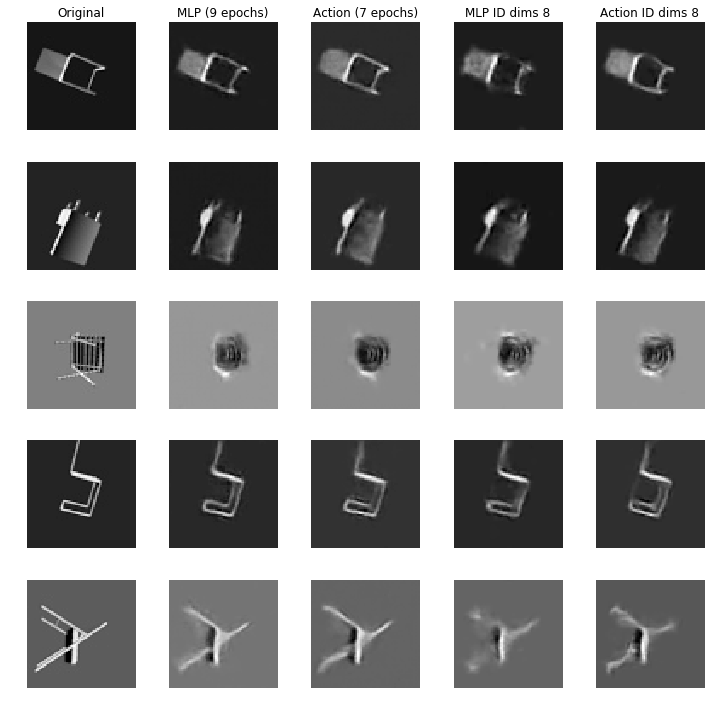

In [9]:
idxs = np.random.choice(len(multi_dataset), size=5, replace=False)
id_label, rot_label, img_label = zip(*[multi_dataset[i] for i in idxs])
id_label = torch.tensor(id_label, dtype=torch.long)
rot_label = torch.stack(rot_label, 0)
img_label = torch.stack(img_label, 0)

action_rec = multi_action_dec_fat(*multi_action_enc_fat(img_label))
mlp_rec = multi_mlp_dec(*multi_mlp_enc(img_label))
action_rec8 = multi_action_dec_fat8(*multi_action_enc_fat8(img_label))
mlp_rec8 = multi_mlp_dec8(*multi_mlp_enc8(img_label))
    
plot_reconstructions([img_label, mlp_rec, action_rec, mlp_rec8, action_rec8],
                     ['Original', 'MLP (9 epochs)', 'Action (7 epochs)', 'MLP ID dims 8', 'Action ID dims 8'])

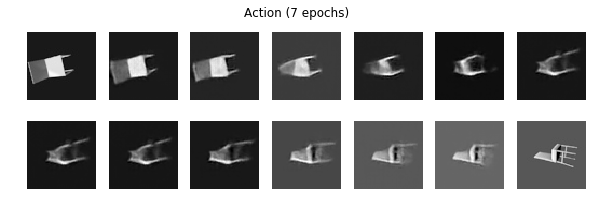

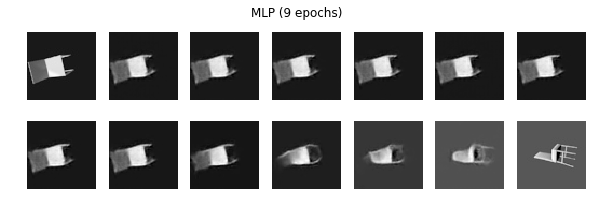

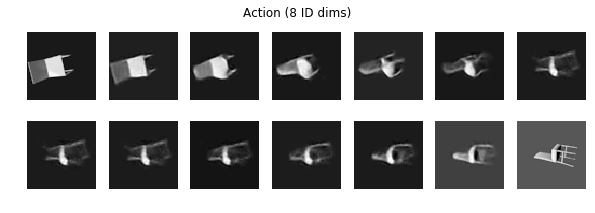

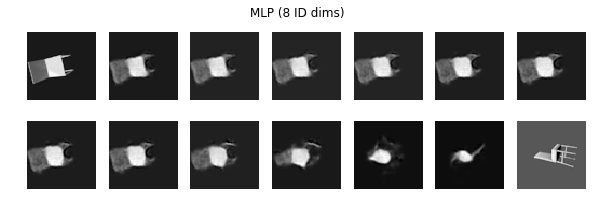

In [36]:
idxs = np.random.choice(len(multi_dataset), size=2, replace=False)
img = torch.stack([multi_dataset[i][2] for i in idxs])

def disentangle(enc, dec, start, end, title):
    imgs = torch.stack([start, end], 0)
    (start_rot, end_rot), (start_cont, end_cont) = enc(imgs)
    start_alg = map2LieVector(log_map(start_rot))
    end_alg = map2LieVector(log_map(end_rot))
    
    n_steps = 6
    
    t = torch.linspace(0, 1, n_steps)[:, None]
    t_first = torch.cat([t, torch.ones_like(t)], 0)
    t_second = torch.cat([torch.zeros_like(t), t], 0)
    rot_traj = rodrigues(start_alg[None] * (1-t_first) + end_alg[None] * t_first)
    cont_traj = start_cont[None] * (1-t_second) + end_cont[None] * t_second
    out = dec(rot_traj, cont_traj)
    
    fig, ax = plt.subplots(2, n_steps+1, figsize=(10, 3))
    for i in range(2):
        for j in range(n_steps+1):
            if i == 0 and j == 0:
                ax[i, j].imshow(start[0].detach(), 'gray')
            elif i == 1 and j == n_steps:
                ax[i, j].imshow(end[0].detach(), 'gray')
            else:
                img_i = n_steps * i + j - 1
                ax[i, j].imshow(out[img_i][0].detach(), 'gray')
            ax[i, j].set_axis_off()
#     fig.tight_layout()
    fig.suptitle(title)
    
disentangle(multi_action_enc_fat, multi_action_dec_fat, img[0], img[1], 'Action (7 epochs)')
disentangle(multi_mlp_enc, multi_mlp_dec, img[0], img[1], 'MLP (9 epochs)')
disentangle(multi_action_enc_fat8, multi_action_dec_fat8, img[0], img[1], 'Action (8 ID dims)')
disentangle(multi_mlp_enc8, multi_mlp_dec8, img[0], img[1], 'MLP (8 ID dims)')

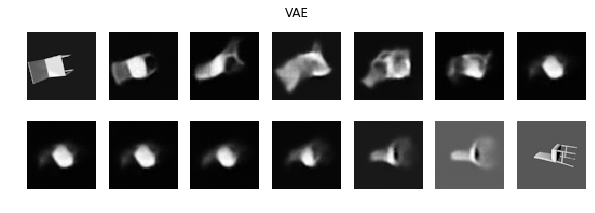

In [38]:
vae = ChairsVAE(
    content_dims=10,
    latent_mode='so3',
    decoder_mode='action',
    deconv_mode='deconv',
    rep_copies=10,
    degrees=6,
    deconv_hidden=50,
    batch_norm=True)
vae.load_state_dict(torch.load('outputs/vae-action-so3-beta-bumpe-4/model.pickle'))

def decode_vae(vae, pose, content):
    return vae.decoder(group_matrix_to_eazyz(pose), content)


def encode_vae(vae, img):
    pose, content = vae.encode(img)
    return [pose[0], content[0]]

disentangle(partial(encode_vae, vae), partial(decode_vae, vae), img[0], img[1], 'VAE')